Experiment E1-1:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = SGD
- lr=1.0e-4

model:
- self.base_model(x)
- self.flatten(x)
- self.fc(x)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-1"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"
config.EPOCHS = 20

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        #self.globalavg = nn.AdaptiveAvgPool2d((1, 1))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(81920, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        #x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.5256 | Train Acc: 0.7369
  Val Loss  : 0.4411 | Val Acc: 0.7900
  Train Precision: 0.7380 | Recall: 0.8032 | F1: 0.7692 | ROC AUC: 0.8156
  Train Confusion Matrix: TN=1044, FP=545, FN=376, TP=1535
  Val Precision: 0.7495 | Recall: 0.9243 | F1: 0.8278 | ROC AUC: 0.8949
  Val Confusion Matrix: TN=428, FP=253, FN=62, TP=757
2
Epoch 2/20
  Train Loss: 0.3905 | Train Acc: 0.8371
  Val Loss  : 0.3885 | Val Acc: 0.8147
  Train Precision: 0.8344 | Recall: 0.8755 | F1: 0.8544 | ROC AUC: 0.9166
  Train Confusion Matrix: TN=1257, FP=332, FN=238, TP=1673
  Val Precision: 0.7862 | Recall: 0.9072 | F1: 0.8424 | ROC AUC: 0.9154
  Val Confusion Matrix: TN=479, FP=202, FN=76, TP=743
3
Epoch 3/20
  Train Loss: 0.3477 | Train Acc: 0.8546
  Val Loss  : 0.3658 | Val Acc: 0.8407
  Train Precision: 0.8540 | Recall: 0.8849 | F1: 0.8692 | ROC AUC: 0.9335
  Train Confusion Matrix: TN=1300, FP=289, FN=220, TP=1691
  Val Precision: 0.8887 | Recall: 0.8095 | F1: 0.8473 | ROC AUC: 0.924

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.525583,0.736857,0.737981,0.803244,0.769231,0.815650,"{'tn': 1044, 'fp': 545, 'fn': 376, 'tp': 1535}",0.441121,0.790000,0.749505,...,0.894940,"{'tn': 428, 'fp': 253, 'fn': 62, 'tp': 757}",1044,545,376,1535,428,253,62,757
1,0.390476,0.837143,0.834414,0.875458,0.854443,0.916551,"{'tn': 1257, 'fp': 332, 'fn': 238, 'tp': 1673}",0.388495,0.814667,0.786243,...,0.915380,"{'tn': 479, 'fp': 202, 'fn': 76, 'tp': 743}",1257,332,238,1673,479,202,76,743
2,0.347711,0.854571,0.854040,0.884877,0.869185,0.933456,"{'tn': 1300, 'fp': 289, 'fn': 220, 'tp': 1691}",0.365819,0.840667,0.888740,...,0.924805,"{'tn': 598, 'fp': 83, 'fn': 156, 'tp': 663}",1300,289,220,1691,598,83,156,663
3,0.312770,0.873714,0.876474,0.894819,0.885552,0.948821,"{'tn': 1348, 'fp': 241, 'fn': 201, 'tp': 1710}",0.358572,0.836000,0.803818,...,0.930396,"{'tn': 496, 'fp': 185, 'fn': 61, 'tp': 758}",1348,241,201,1710,496,185,61,758
4,0.286834,0.886286,0.884596,0.910518,0.897370,0.958535,"{'tn': 1362, 'fp': 227, 'fn': 171, 'tp': 1740}",0.328542,0.860000,0.866426,...,0.935850,"{'tn': 570, 'fp': 111, 'fn': 99, 'tp': 720}",1362,227,171,1740,570,111,99,720
5,0.270229,0.898571,0.902275,0.913134,0.907672,0.963439,"{'tn': 1400, 'fp': 189, 'fn': 166, 'tp': 1745}",0.319698,0.860667,0.882206,...,0.939558,"{'tn': 587, 'fp': 94, 'fn': 115, 'tp': 704}",1400,189,166,1745,587,94,115,704
6,0.253993,0.907143,0.910031,0.920984,0.915475,0.968470,"{'tn': 1415, 'fp': 174, 'fn': 151, 'tp': 1760}",0.313833,0.862667,0.862722,...,0.941699,"{'tn': 565, 'fp': 116, 'fn': 90, 'tp': 729}",1415,174,151,1760,565,116,90,729
7,0.241797,0.915429,0.917744,0.928310,0.922997,0.972348,"{'tn': 1430, 'fp': 159, 'fn': 137, 'tp': 1774}",0.311605,0.865333,0.873035,...,0.941589,"{'tn': 576, 'fp': 105, 'fn': 97, 'tp': 722}",1430,159,137,1774,576,105,97,722
8,0.233050,0.913429,0.912731,0.930403,0.921482,0.974025,"{'tn': 1419, 'fp': 170, 'fn': 133, 'tp': 1778}",0.300685,0.869333,0.883149,...,0.946319,"{'tn': 586, 'fp': 95, 'fn': 101, 'tp': 718}",1419,170,133,1778,586,95,101,718
9,0.219639,0.925714,0.927056,0.937729,0.932362,0.978048,"{'tn': 1448, 'fp': 141, 'fn': 119, 'tp': 1792}",0.303053,0.858667,0.892626,...,0.946288,"{'tn': 598, 'fp': 83, 'fn': 129, 'tp': 690}",1448,141,119,1792,598,83,129,690


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.441121  0.790000       0.749505    0.924298  0.827775    0.894940
1   0.388495  0.814667       0.786243    0.907204  0.842404    0.915380
2   0.365819  0.840667       0.888740    0.809524  0.847284    0.924805
3   0.358572  0.836000       0.803818    0.925519  0.860386    0.930396
4   0.328542  0.860000       0.866426    0.879121  0.872727    0.935850
5   0.319698  0.860667       0.882206    0.859585  0.870748    0.939558
6   0.313833  0.862667       0.862722    0.890110  0.876202    0.941699
7   0.311605  0.865333       0.873035    0.881563  0.877278    0.941589
8   0.300685  0.869333       0.883149    0.876679  0.879902    0.946319
9   0.303053  0.858667       0.892626    0.842491  0.866834    0.946288
10  0.299526  0.871333       0.888337    0.874237  0.881231    0.945767
11  0.295873  0.874667       0.864740    0.913309  0.888361    0.947908
12  0.300346  0.870667       0.917223    0.838828  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.00000
mean,0.248851,0.906271,0.906381,0.924804,0.915437,0.963692,0.316281,0.860967,0.871750,0.878327,0.873769,0.940890,1404.650000,184.350000,143.700000,1767.300000,572.100000,108.900000,99.65000,719.35000
std,0.089285,0.050649,0.050450,0.037706,0.044269,0.039839,0.041936,0.023844,0.043054,0.029841,0.017420,0.014699,105.703296,105.703296,72.055607,72.055607,48.658747,48.658747,24.43956,24.43956
min,0.165437,0.736857,0.737981,0.803244,0.769231,0.815650,0.278708,0.790000,0.749505,0.809524,0.827775,0.894940,1044.000000,103.000000,70.000000,1535.000000,428.000000,62.000000,61.00000,663.00000
25%,0.188438,0.895500,0.897855,0.912480,0.905097,0.962213,0.290368,0.859667,0.866004,0.860501,0.869770,0.938631,1390.500000,116.750000,97.250000,1743.750000,568.750000,81.750000,81.25000,704.75000
50%,0.219172,0.924000,0.923290,0.937729,0.930911,0.977764,0.300515,0.870000,0.884414,0.877900,0.878590,0.946304,1439.500000,149.500000,119.000000,1792.000000,586.500000,94.500000,100.00000,719.00000
75%,0.274380,0.938643,0.939499,0.949110,0.944086,0.984583,0.321909,0.874167,0.897733,0.900794,0.882853,0.950191,1472.250000,198.500000,167.250000,1813.750000,599.250000,112.250000,114.25000,737.75000
max,0.525583,0.950571,0.947016,0.963370,0.955123,0.989917,0.441121,0.884000,0.917223,0.925519,0.895307,0.952820,1486.000000,545.000000,376.000000,1841.000000,619.000000,253.000000,156.00000,758.00000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.248851   0.906271         0.906381      0.924804   0.915437   
std      0.089285   0.050649         0.050450      0.037706   0.044269   
min      0.165437   0.736857         0.737981      0.803244   0.769231   
25%      0.188438   0.895500         0.897855      0.912480   0.905097   
50%      0.219172   0.924000         0.923290      0.937729   0.930911   
75%      0.274380   0.938643         0.939499      0.949110   0.944086   
max      0.525583   0.950571         0.947016      0.963370   0.955123   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     20.000000  20.000000  20.000000      20.000000   20.000000   
mean       0.963692   0.316281   0.860967       0.871750    0.878327   
std        0.039839   0.041936   0.023844       0.043054    0.029841   
min        0.815650   0.278708   0.790000    

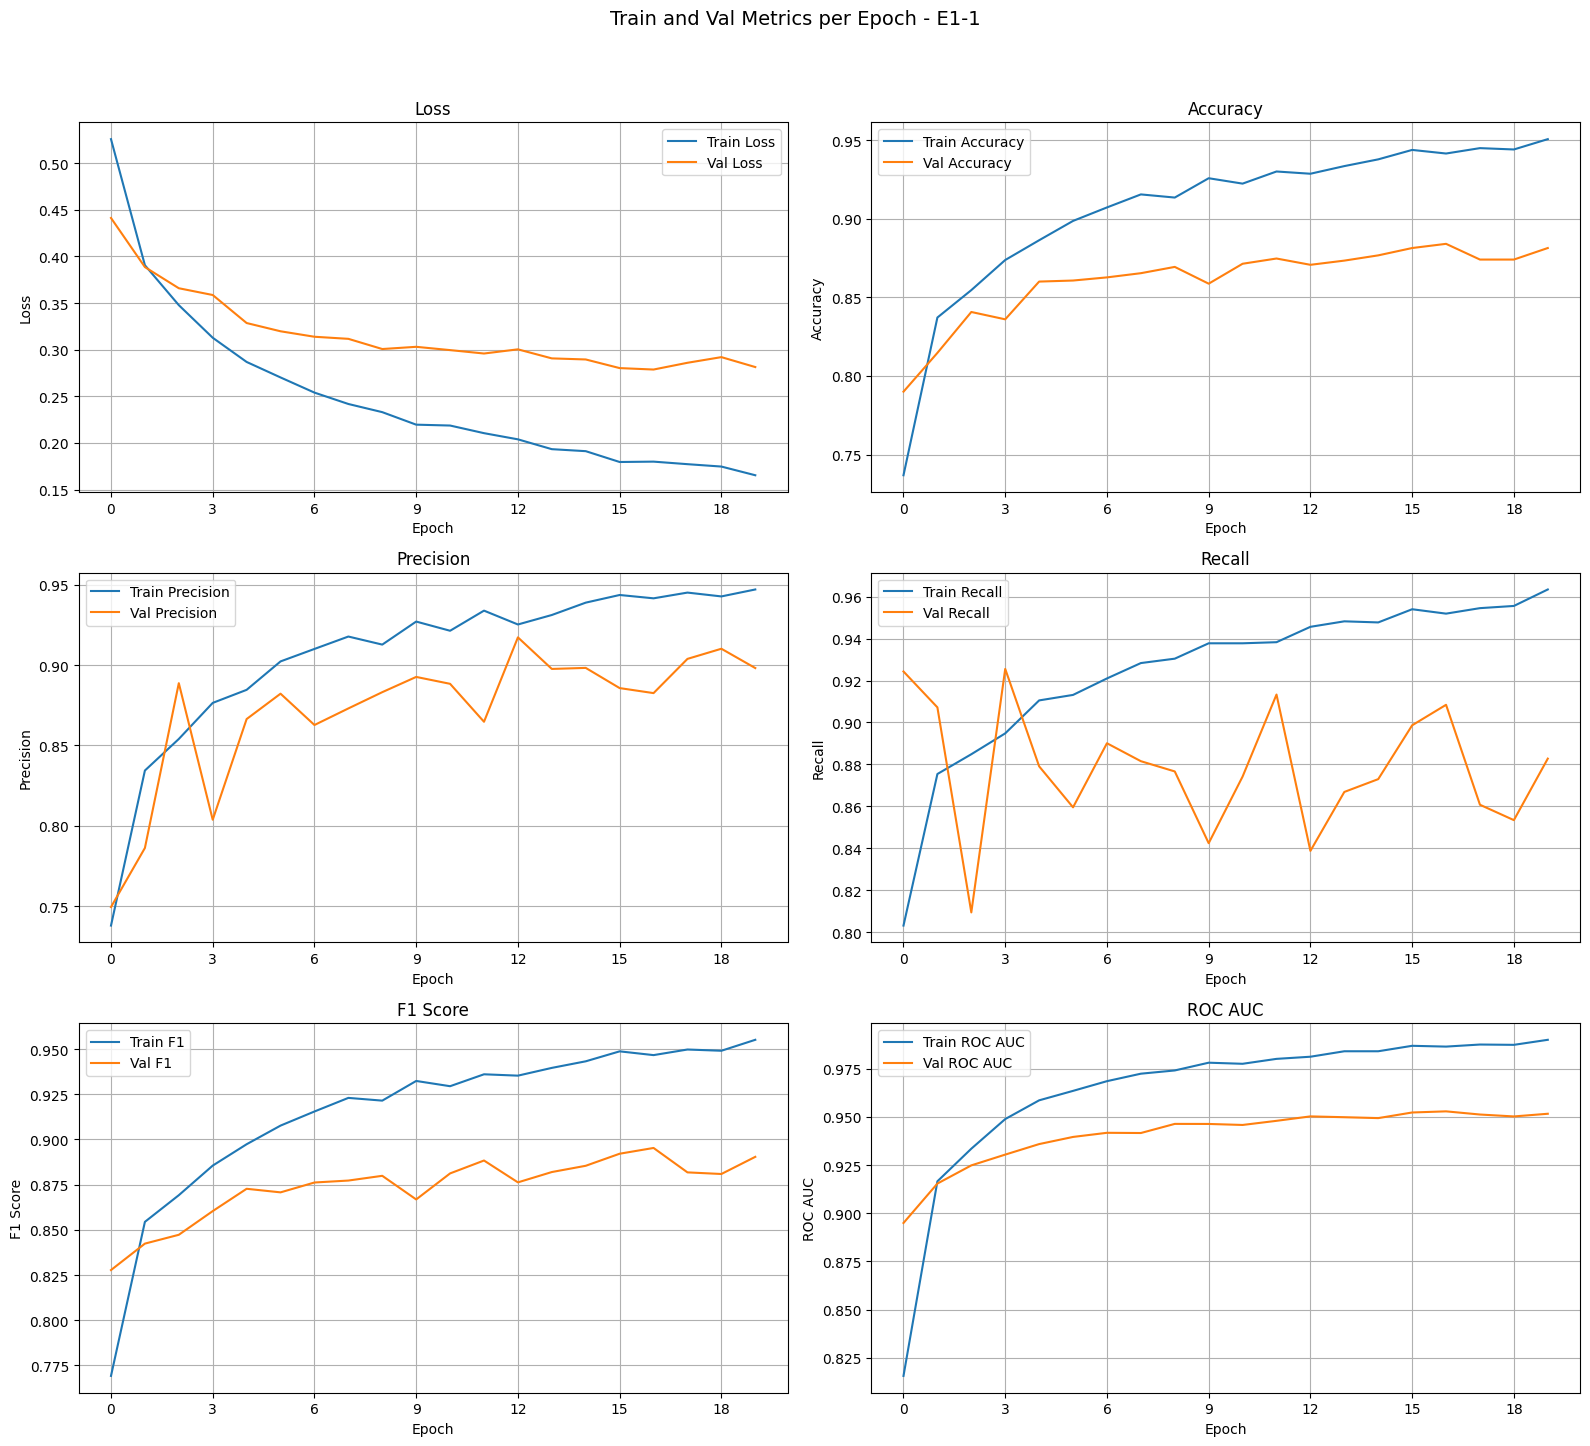

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)